# Imports

In [1]:
# third-party Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load data

In [44]:
vuln = pd.read_csv('../output/vulnerabilities.csv')

In [45]:
vuln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200473 entries, 0 to 200472
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cve_id                   200473 non-null  object 
 1   cwe                      200473 non-null  object 
 2   part                     200473 non-null  object 
 3   vendor                   200473 non-null  object 
 4   product                  200473 non-null  object 
 5   description              200473 non-null  object 
 6   cvss_type                189119 non-null  float64
 7   attack_vector            189119 non-null  object 
 8   attack_complexity        189119 non-null  object 
 9   privileges_required      189119 non-null  object 
 10  user_interaction         188982 non-null  object 
 11  scope                    115786 non-null  object 
 12  confidentiality_impact   189119 non-null  object 
 13  integrity_impact         189119 non-null  object 
 14  avai

# Preparing Data

In [5]:
# transforming date columns in datetime to easy manipulation
vuln['cve_published_date'] = pd.to_datetime(vuln['cve_published_date'], format='%Y-%m-%d')
vuln['exploit_published_date'] = pd.to_datetime(vuln['exploit_published_date'], format='%Y-%m-%d', errors='coerce')
vuln['cve_last_modified_date'] = pd.to_datetime(vuln['cve_last_modified_date'], format='%Y-%m-%d', errors='coerce')

In [6]:
# replacing NaN value in cvssType for 0
vuln['cvss_type'].replace(np.nan, 0, inplace=True)

In [7]:
# transforming status in categories
vuln['base_severity'] = pd.Categorical(
    vuln.base_severity, categories=['LOW', 'MEDIUM', 'HIGH', 'CRITICAL'], ordered=True)

In [8]:
# transforming columns in lists
vuln['cwe'] = vuln['cwe'].apply(eval)
vuln['part'] = vuln['part'].apply(eval)
vuln['vendor'] = vuln['vendor'].apply(eval)
vuln['product'] = vuln['product'].apply(eval)

In [9]:
# creating a field to help in the analysis
vuln['exploit_available'] = np.where(vuln['exploit_count'] > 0, 1, 0)

# Utils

In [10]:
def to_1D(series):
     return pd.Series([x for _list in series for x in _list])

# Analysis

In [11]:
vuln = vuln.query("cve_published_date >= '2017-01-01' & cve_published_date < '2022-01-01'")

In [12]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

## Amount of vulnerabilities published by year

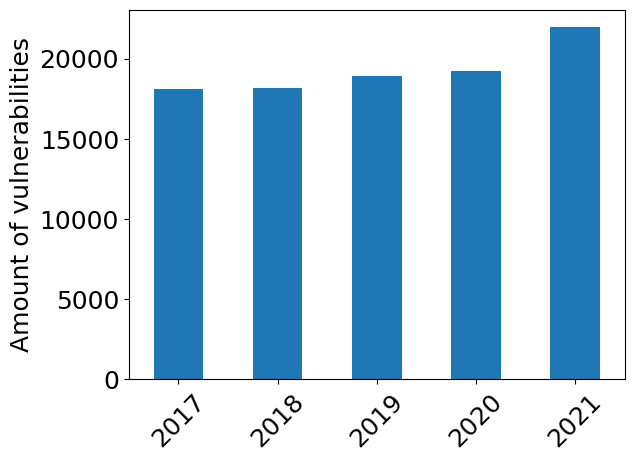

In [13]:
plotdata = vuln.groupby(vuln['cve_published_date'].dt.year, sort=True)['cve_id'].count()
plotdata.plot(kind='bar', title='', xlabel='', ylabel='', rot=45)

plt.ylabel('Amount of vulnerabilities')
plt.savefig('images/vulnerability_per_year.pdf', dpi=1200, bbox_inches='tight')

## Distribution of vulnerabilities by CVSS severity

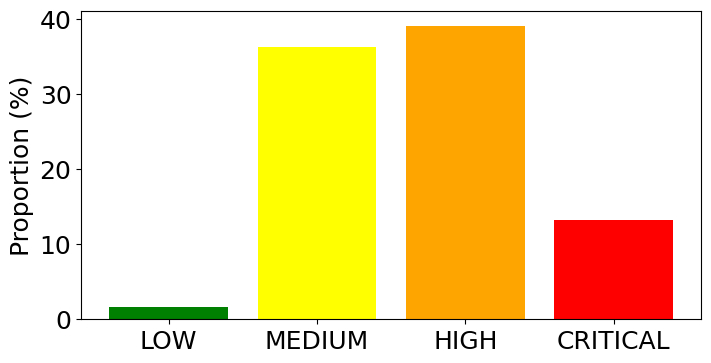

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

total = vuln.shape[0]

colors = ['green', 'yellow', 'orange', 'red']

severity = vuln.groupby('base_severity')['cve_id'].count()

ax.bar(severity.index, [value / total * 100 for value in severity.values], color=colors)

ax.set_ylabel('Proportion (%)')

plt.savefig('images/vulnerability_per_severity.pdf', dpi=1200, bbox_inches='tight')

## Amount of vulnerabilities by year and severity

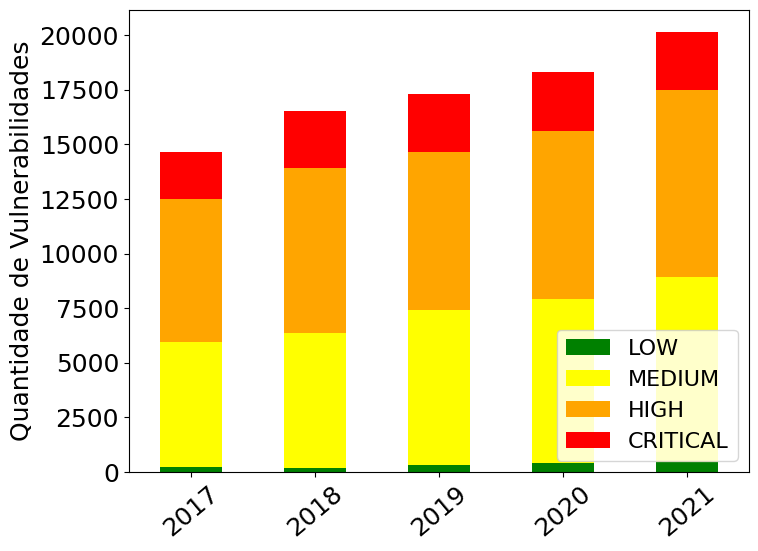

In [15]:
plotdata = vuln.groupby([vuln['cve_published_date'].dt.year, vuln['base_severity']])['cve_id'].count()
plotdata.unstack().plot(
    kind='bar', color=['green', 'yellow', 'orange', 'red'], stacked=True,
    title='', xlabel='', ylabel='Quantidade de Vulnerabilidades', rot=40, figsize=(8,6))

plt.legend(loc='lower right')
plt.savefig('images/vulnearbility_by_year_and_severity.pdf', dpi=1200, bbox_inches='tight')

## CIA Distribution

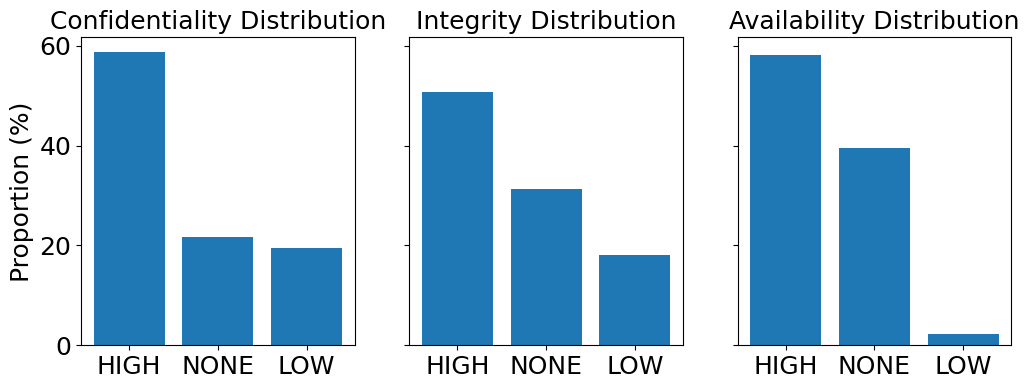

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4), sharey=True)

vuln_with_cvssV3 = vuln.loc[vuln['cvss_type'] == 3]

ci_counts = vuln_with_cvssV3['confidentiality_impact'].value_counts().values
cis = [value / sum(ci_counts) * 100 for value in ci_counts]

ax1.bar(['HIGH', 'NONE', 'LOW'], cis)
ax1.set_ylabel('Proportion (%)')
ax1.set_title('Confidentiality Distribution')

ii_counts = vuln_with_cvssV3['integrity_impact'].value_counts().values
iis = [value / sum(ii_counts) * 100 for value in ii_counts]

ax2.bar(['HIGH', 'NONE', 'LOW'], iis)
ax2.set_title('Integrity Distribution')

ai_counts = vuln_with_cvssV3['availability_impact'].value_counts().values
ais = [value / sum(ai_counts) * 100 for value in ai_counts]

ax3.bar(['HIGH', 'NONE', 'LOW'], ais)
ax3.set_title('Availability Distribution')

plt.savefig('images/cia_distribution.pdf', dpi=1200, bbox_inches='tight') 

## Amount of exploitable vulnerability by year

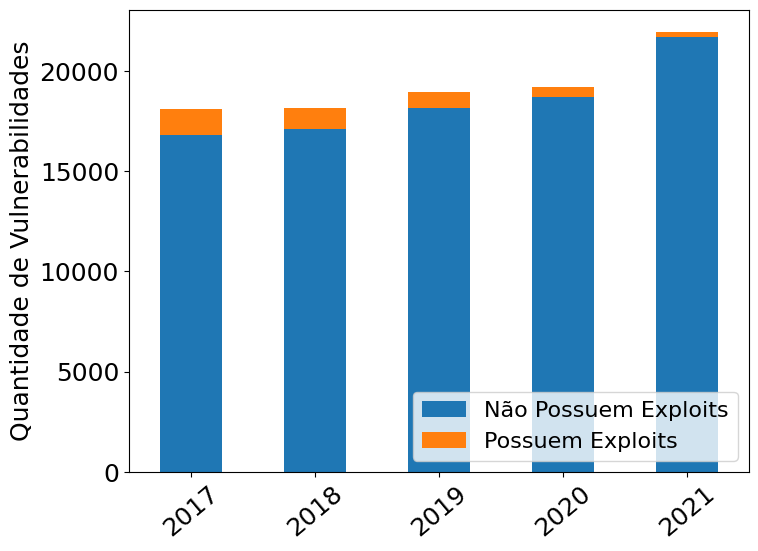

In [17]:
plotdata = vuln.groupby([vuln['cve_published_date'].dt.year, vuln['exploit_available']])['cve_id'].count()
plotdata.unstack().plot(kind='bar', stacked=True, title='', xlabel='', ylabel='Quantidade de Vulnerabilidades', rot=40, figsize=(8,6))

plt.legend(['Não Possuem Exploits', 'Possuem Exploits'], loc='lower right')
plt.savefig('images/exploits_by_year.pdf', dpi=1200, bbox_inches='tight')  

## Distribution of exploit by severity

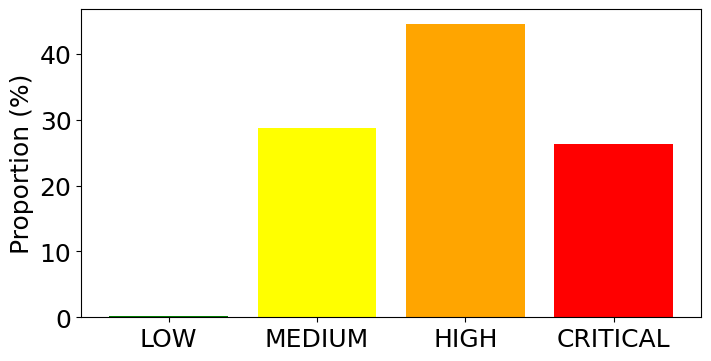

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

severities = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
colors = ['green', 'yellow', 'orange', 'red']

vuln_with_exploit = vuln.query('exploit_available == 1').groupby('base_severity')['cve_id'].count()

total = sum(vuln_with_exploit.values)
values = [value / total * 100 for value in vuln_with_exploit.values]

ax.bar(severities, values, color=colors)
ax.set_ylabel('Proportion (%)')

plt.savefig('images/exploit_by_severity.pdf', dpi=1200, bbox_inches='tight')  

## Most Affected CWE

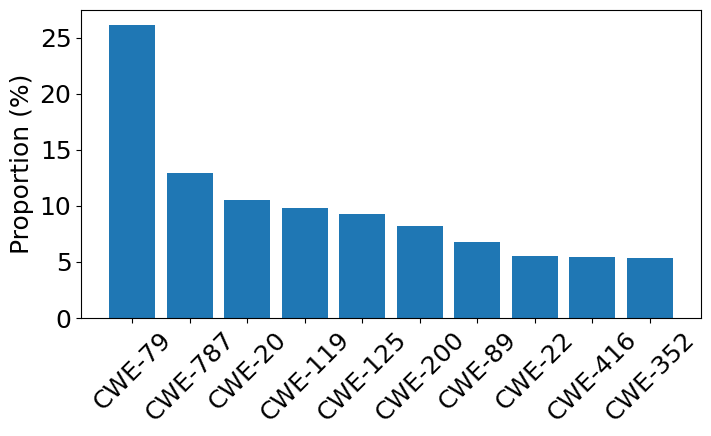

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

values_array = to_1D(vuln['cwe']).value_counts()[1:11].values
values = [value / sum(values_array) * 100 for value in values_array]

ax.bar(to_1D(vuln['cwe']).value_counts()[1:11].index, values)
ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=45)
plt.savefig('images/affected_cwe.pdf', dpi=1200, bbox_inches='tight')  

## Mitre and OWASP

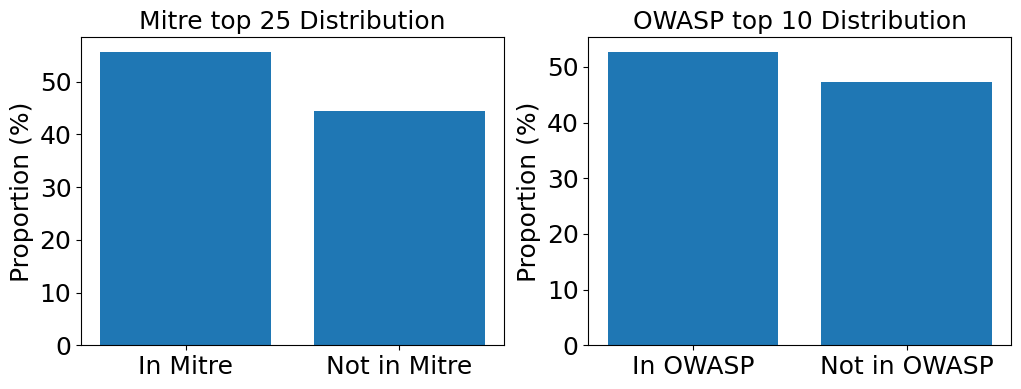

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

mitre_counts = vuln['mitre_top_25'].value_counts().values
mitres = [value / sum(mitre_counts) * 100 for value in mitre_counts]

ax1.bar(['In Mitre', 'Not in Mitre'], mitres)
ax1.set_ylabel('Proportion (%)')
ax1.set_title('Mitre top 25 Distribution')

owasp_counts = vuln['owasp_top_10'].value_counts().values
owasps = [value / sum(owasp_counts) * 100 for value in owasp_counts]

ax2.bar(['In OWASP', 'Not in OWASP'], owasps)
ax2.set_ylabel('Proportion (%)')
ax2.set_title('OWASP top 10 Distribution')

plt.savefig('images/mitre_owasp.pdf', dpi=1200, bbox_inches='tight')  

## Vulnerability distribution by platform

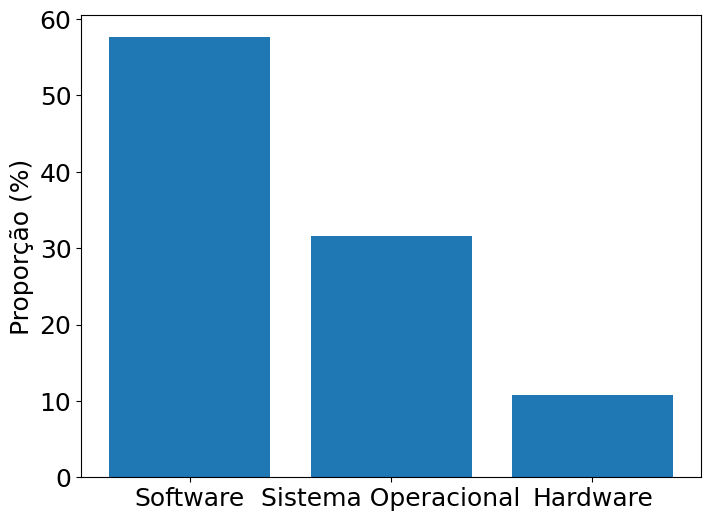

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

parts = to_1D(vuln['part']).value_counts()
total = sum(parts.values)

values = [value / total * 100 for value in parts.values]

ax.bar(['Software', 'Sistema Operacional', 'Hardware'], values)
ax.set_ylabel('Proporção (%)')

plt.savefig('images/vuln_part.pdf', dpi=1200, bbox_inches='tight')

## Vulnerability distribution by vendor

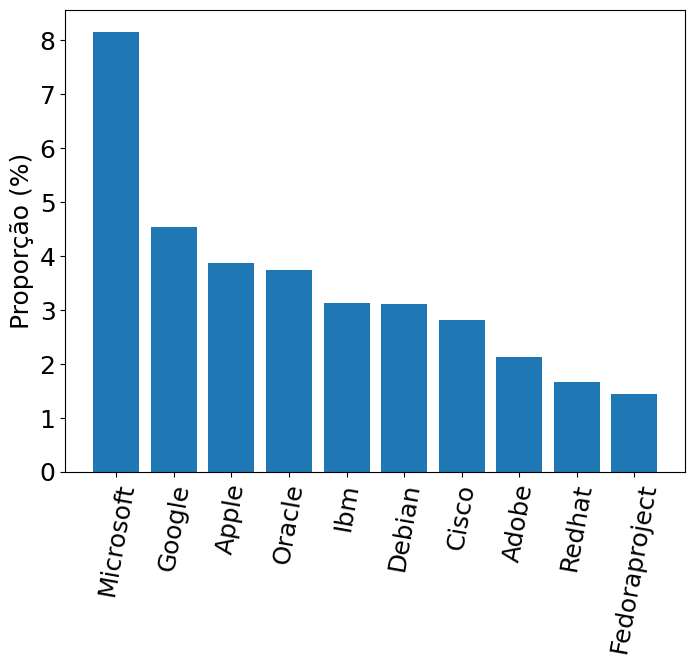

In [22]:
fig, ax = plt.subplots(figsize=(8,6))


vendors = to_1D(vuln['vendor']).value_counts()
total = sum(vendors.values)

values = [value / total * 100 for value in vendors.values[0:10]]
indexes = [index.capitalize() for index in vendors.index[0:10]]
# indexes[-1] = f'Other-Linux\n distros'

ax.bar(indexes, values)

ax.set_ylabel('Proporção (%)')

plt.xticks(rotation=80)
plt.savefig('images/affected_vendor.pdf', dpi=1200, bbox_inches='tight')

## Vulnerability distribution by product

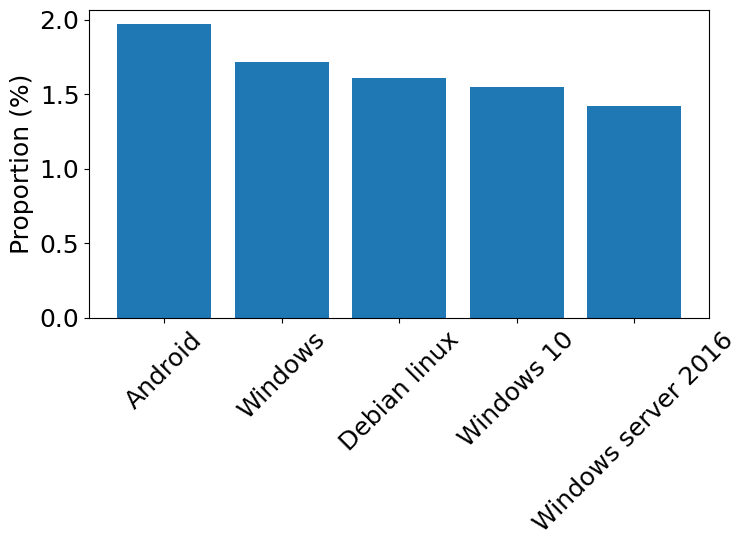

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

products = to_1D(vuln['product']).value_counts()
total = sum(products.values)

values = [value / total * 100 for value in products.values[0:5]]
indexes = [value.replace('_', ' ').capitalize() for value in products.index[0:5]]

ax.bar(indexes, values)

ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=45)
plt.savefig('images/affected_product.pdf', dpi=1200, bbox_inches='tight')  

## EPSS

In [24]:
epss = vuln.loc[
    (vuln['base_score'] >= 9.0) & (vuln['epss'] >= 0.9) & (vuln['exploit_count'].isnull())]

columns = [
    'cve_id', 'cve_published_date', 'base_score', 
    'confidentiality_impact', 'integrity_impact', 
    'availability_impact', 'epss']
epss.sort_values(by='epss', ascending=False)[columns].head(10)

,cve_id,cve_published_date,base_score,confidentiality_impact,integrity_impact,availability_impact,epss
178784,CVE-2021-40438,2021-09-16,9.0,HIGH,HIGH,HIGH,0.97224
168851,CVE-2021-26295,2021-03-22,9.8,HIGH,HIGH,HIGH,0.96064
181207,CVE-2021-44077,2021-11-29,9.8,HIGH,HIGH,HIGH,0.96021
152525,CVE-2020-2551,2020-01-15,9.8,HIGH,HIGH,HIGH,0.95975
147614,CVE-2020-14750,2020-11-02,9.8,HIGH,HIGH,HIGH,0.95975
178875,CVE-2021-40539,2021-09-07,9.8,HIGH,HIGH,HIGH,0.95954
177404,CVE-2021-38647,2021-09-15,9.8,HIGH,HIGH,HIGH,0.95952
128287,CVE-2019-11580,2019-06-03,9.8,HIGH,HIGH,HIGH,0.95885
148355,CVE-2020-15505,2020-07-07,9.8,HIGH,HIGH,HIGH,0.95523
149817,CVE-2020-17496,2020-08-12,9.8,HIGH,HIGH,HIGH,0.95381


## Attack type

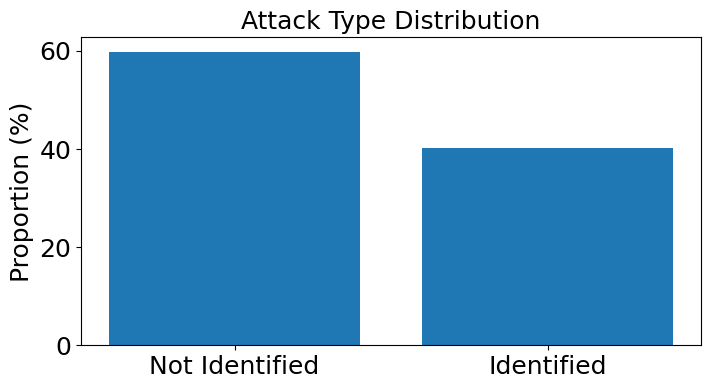

In [25]:
vulns_without_attack_type = vuln.loc[vuln['attack_type'].isnull()].shape[0]
vulns_with_attack_type = vuln.shape[0] - vulns_without_attack_type

fig, ax = plt.subplots(figsize=(8, 4))

attacks = [vulns_without_attack_type / vuln.shape[0] * 100, vulns_with_attack_type / vuln.shape[0] * 100]

ax.bar(['Not Identified', 'Identified'], attacks)
ax.set_ylabel('Proportion (%)')
ax.set_title('Attack Type Distribution')

plt.savefig('images/attack_type.pdf', dpi=1200, bbox_inches='tight') 

## Attack type distribution

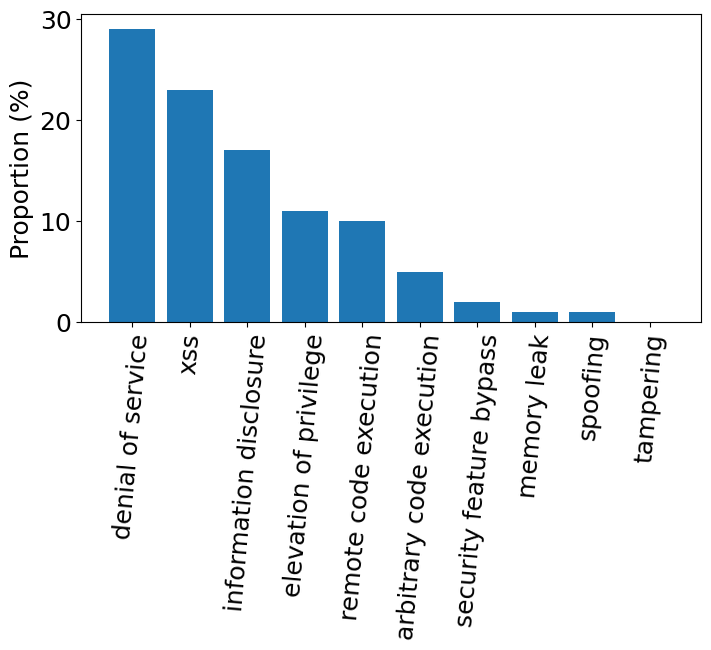

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))

attacks = vuln.loc[~vuln['attack_type'].isnull()]
attacks['attack_type'] = attacks['attack_type'].apply(eval)

attack_counts = to_1D(attacks['attack_type']).value_counts()[:10]
attacks = [round(value / sum(attack_counts) * 100) for value in attack_counts]

ax.bar(attack_counts.index, attacks)

ax.set_ylabel('Proportion (%)')

plt.xticks(rotation=85)
plt.savefig('images/attack_type_distribution.pdf', dpi=1200, bbox_inches='tight') 

## Update available

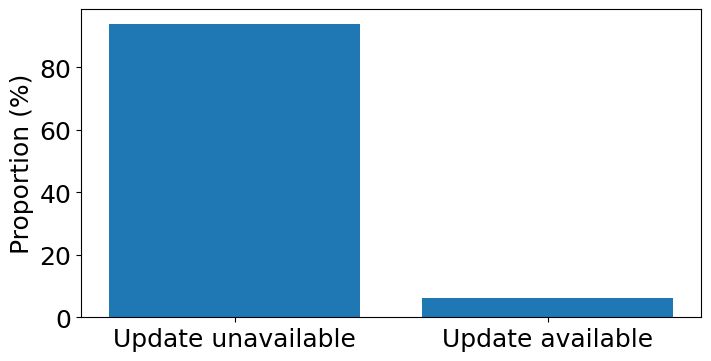

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

update_counts = vuln['update_available'].value_counts().values
updates = [value / sum(update_counts) * 100 for value in update_counts]

ax.bar(['Update unavailable', 'Update available'], updates)
ax.set_ylabel('Proportion (%)')

plt.savefig('images/updatable_cve.pdf', dpi=1200, bbox_inches='tight') 

## Twitter

In [28]:
audience = vuln.loc[~vuln['audience'].isnull()].sort_values(by='audience', ascending=False)
audience.head(10)[['cve_id', 'base_score', 'audience']]

,cve_id,base_score,audience
181309,CVE-2021-44228,10.0,97684.0
177740,CVE-2021-39144,8.5,34006.0
113361,CVE-2018-13379,9.8,10191.0
138787,CVE-2019-5482,9.8,7765.0
170720,CVE-2021-29251,6.5,7115.0
147209,CVE-2020-14356,7.8,4145.0
121985,CVE-2018-4920,8.8,3884.0
121984,CVE-2018-4919,8.8,3884.0
122001,CVE-2018-4936,6.5,3883.0
122002,CVE-2018-4937,8.8,3883.0
